In [4]:
import pandas as pd
import json
from IPython.display import display
import os
import numpy as np

In [5]:
def load_data_to_df(filepath):
    with open(filepath, 'rb') as f:
        res = json.load(f)
    res = res['results']

    df = pd.concat([pd.DataFrame(r) for r in res], axis=0, keys=range(len(res)))
    df = pd.concat([df, df['hyperparam'].apply(pd.Series)], axis=1).drop(columns='hyperparam')
    df = df.rename_axis(['rollout', 'config_id'], axis='index')
    return df


def select_hparams(df, hparam_config):
    # Select results for specific hparams
    if hparam_config:
        for key, val in hparam_config.items():
            if not isinstance(val, list):
                val = [val]
            df = df[df[key].isin(val)]
    return df


# Best hparam configs
def get_best_hparam_results(df, metric='val_loss', num_best=10000, hparam_config=None):
    if hparam_config:
        df = select_hparams(df, hparam_config)

    best = df.groupby('config_id').mean().sort_values(by=metric)[:num_best]
    return best


def get_mean_and_sem(df, test_metric='test_risk', val_metric='val_loss', hparam_config=None):
    if df.reset_index()['config_id'].nunique() > 1:
        best = get_best_hparam_results(df, metric=val_metric, num_best=1, hparam_config=hparam_config).reset_index()
        best_config_id = best.loc[0].config_id
    else:
        best_config_id = 0

    df = df.reset_index()
    df = df[df["config_id"]==best_config_id]
    return df[test_metric].mean(), df[test_metric].sem()

def plot_validation_loss(df, config_id):
    for rollout in range(df.reset_index()['rollout'].nunique()):
        plt.plot(df.loc[rollout].loc[config_id].train_stats['val_loss'])
        
    plt.title(f'val_loss: {df.loc[rollout].loc[config_id].val_loss_func}')
    print(df.groupby('config_id').mean().loc[config_id])

In [6]:
# Merge datasets
def load_and_merge_datasets(filepaths=None, property_dict=None, merge='hparam_configs', load_all_in_dir=None, method=None):
    assert (load_all_in_dir and method) or (load_all_in_dir is None and method is None)
    
    if isinstance(filepaths, str):
        filepaths = [filepaths]
    elif filepaths is None and load_all_in_dir:
        filelist = os.listdir(load_all_in_dir)
        filepaths = []
        for fp in filelist:
            if method in fp:
                filepaths.append(load_all_in_dir + fp)
        
    if merge == 'rollouts':
        merge_property = 'rollout'
    elif merge == 'hparam_configs':
        merge_property = 'config_id'
    else:
        raise NotImplementedError
    
    if not property_dict:
        prop_name = 'version'
        vals = range(len(filepaths))
    else:
        prop_name = list(property_dict.keys())[0]
        vals = property_dict[prop_name]
        
    start_merge_id = 0
    dfs = []
                
    successful = 0
    for filepath, prop in zip(filepaths, vals):
        try:
            data_frame = load_data_to_df(filepath)
            data_frame = data_frame.drop(columns=['test_risk_optim', 'parameter_mse_optim', 'best_index'])
            data_frame[prop_name] = prop

            # Add new config id
            data_frame = data_frame.reset_index()
            data_frame[merge_property] += start_merge_id
            start_merge_id = data_frame[merge_property].max() + 1
            dfs.append(data_frame)
            successful += 1
        except FileNotFoundError:
            pass
            # print('File not found:', filepath)
    print(f'Found {successful}/{len(filepaths)} files.')

    df = pd.concat(dfs, ignore_index=True)
    df = df.set_index(['rollout', 'config_id'])
    return df

filepath1 = '../results/bennet_hetero/bennet_hetero_method=KMM-RF_n=2000.json'
filepath2 = '../results/bennet_hetero/bennet_hetero_method=KMM-RF_n=2000.json'
fps = [filepath1, filepath2]
property_dict = {'divergence': ['kl', 'log']}

df1 = load_data_to_df(filepath1)
df2 = load_data_to_df(filepath2)
df3 = load_and_merge_datasets(fps, property_dict)

print(get_mean_and_sem(df1))
print(get_mean_and_sem(df2))
print(get_mean_and_sem(df3))

best = get_best_hparam_results(df3, metric='test_risk')
best

df = load_and_merge_datasets('../results/bennet_hetero/bennet_hetero_method=KMM-RF_n=2000.json')
best = get_best_hparam_results(df, metric='test_risk', num_best=20)
best

# EXP1: Bennett Hetero

In [22]:
n = 2000


vmm = load_and_merge_datasets(load_all_in_dir=f"/Users/hkremer/code/kmm/wasserstein-method-of-moments/results/bennet_hetero/n_{n}/",
                              method="VMM-neural")
    
    
fgel = load_and_merge_datasets(load_all_in_dir=f"/Users/hkremer/code/kmm/wasserstein-method-of-moments/results/bennet_hetero/n_{n}/",
                              method="FGEL-neural")    
    
kmm = load_and_merge_datasets(load_all_in_dir=f"/Users/hkremer/code/kmm/wasserstein-method-of-moments/results/bennet_hetero/n_{n}/",
                              method="KMM")

Found 15/15 files.
Found 45/45 files.
Found 132/132 files.


## VMM

In [23]:
best_vmm = get_best_hparam_results(vmm, metric='val_loss', hparam_config={'val_loss_func': 'hsic',
                                                                         'reg_param': [0, 1e-4, 1e-2, 1e0]})
best_vmm

,test_risk,mse,val_loss,reg_param,version
config_id,,,,,
4,0.220875,0.255754,0.014734,0.0000,4.0
2,0.238899,0.311646,0.015047,0.0100,2.0
10,0.269858,0.366098,0.015847,0.0001,10.0
13,0.545288,0.882195,0.022733,1.0000,13.0


test_risk    0.226658
mse          0.150483
val_loss     0.828801
reg_param    0.000000
version      8.000000
Name: 8, dtype: float64


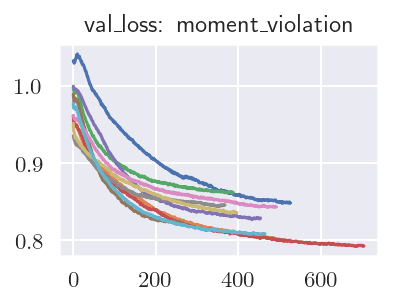

In [24]:
plot_validation_loss(vmm, config_id=8)

## FGEL

In [26]:
best_fgel = get_best_hparam_results(fgel, metric='val_loss', hparam_config={'val_loss_func': 'hsic',
                                                                            'reg_param': [0, 1e-4, 1e-2, 1e0],
                                                                            #'divergence': 'kl',
                                                                           })
best_fgel

,test_risk,mse,val_loss,reg_param,version
config_id,,,,,
29,0.144541,0.174294,0.008741,0.0000,29.0
20,0.126703,0.150199,0.009283,0.0000,20.0
0,0.156115,0.207684,0.009656,0.0001,0.0
19,0.136567,0.163568,0.009718,0.0100,19.0
4,0.187754,0.277757,0.009987,0.0001,4.0
42,0.175892,0.228730,0.010033,0.0100,42.0
37,0.175295,0.230345,0.010384,0.0000,37.0
10,0.194704,0.269246,0.010426,0.0100,10.0
43,0.213059,0.275351,0.011357,0.0001,43.0


test_risk     0.126703
mse           0.150199
val_loss      0.009283
reg_param     0.000000
version      20.000000
Name: 20, dtype: float64


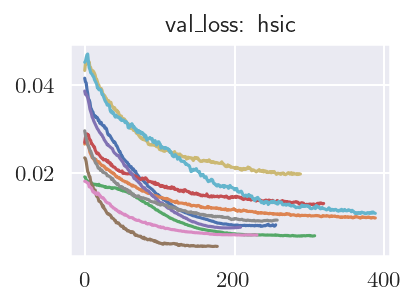

In [27]:
plot_validation_loss(fgel, config_id=20)

## KMM

In [454]:
best_kmm = get_best_hparam_results(kmm, metric='val_loss', hparam_config={'val_loss_func': 'moment_violation',
                                                                         'reg_param': [0, 1e-4, 1e-2, 1e0]})
best_kmm

,test_risk,mse,val_loss,n_reference_samples,entropy_reg_param,reg_param,kde_bw,n_random_features,version
config_id,,,,,,,,,


test_risk                  0.130963
mse                        0.179380
val_loss                   0.007492
n_reference_samples        0.000000
entropy_reg_param         10.000000
reg_param                  1.000000
kde_bw                     0.100000
n_random_features      10000.000000
version                   84.000000
Name: 84, dtype: float64


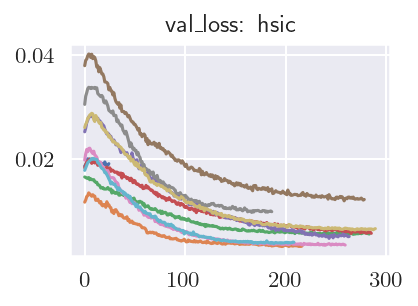

In [291]:
plot_validation_loss(kmm, config_id=84)

In [10]:
get_mean_and_sem(kmm, test_metric='test_risk', val_metric='val_loss', hparam_config={
                                       'val_loss_func': 'moment_violation',
                                       "n_reference_samples": [200], 
                                       "entropy_reg_param": [1],
                                       "reg_param": [1],
                                       'kde_bw': 0.1}
                )

553.0


(0.15384883212014325, 0.02518858038594249)

KeyError: 'rkhs_func_z_dependent'

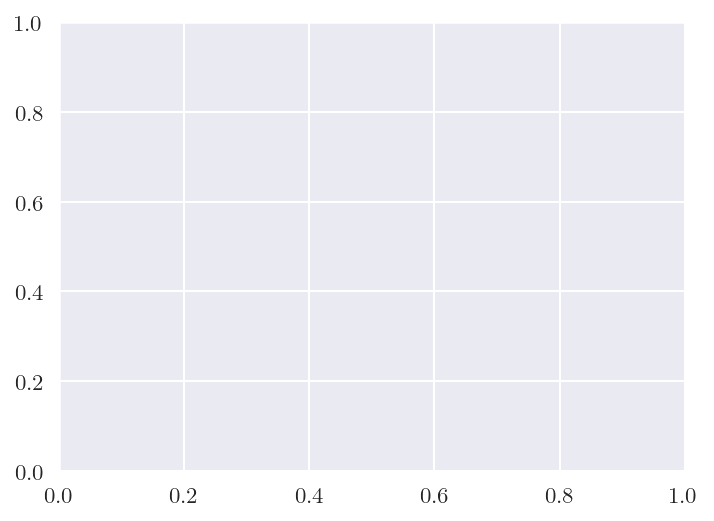

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from cmr.utils.plot import NEURIPS_RCPARAMS, LINE_WIDTH

plt.rcParams.update(NEURIPS_RCPARAMS)
sns.set_theme()
figsize = (LINE_WIDTH/1.3, LINE_WIDTH / 1.8)

fig, ax = plt.subplots(1, 1, figsize=figsize)

n_refs = [0, 100, 200]
for divergence in ['kl']:
    mean = []
    std = []
    for n_ref in n_refs:
        m, s = get_mean_and_sem(kmm, test_metric='test_risk', val_metric='val_loss', hparam_config={'rkhs_func_z_dependent': 1.0,
                                       'val_loss_func': 'moment_violation',
                                       "n_reference_samples": n_ref, 
                                       "entropy_reg_param": [1],
                                       "reg_param": [1],
                                       'kde_bw': 0.1,
                                       'divergence': divergence})
        mean.append(m)
        std.append(s)
    ax.errorbar(n_refs, mean, std)
    

# EXP1.1: Bennett Hetero Optimization Parameters

In [45]:
n = 2000
kmm = load_and_merge_datasets(load_all_in_dir=f"/Users/hkremer/code/kmm/wasserstein-method-of-moments/results/bennet_hetero_opt/n_{n}/",
                              method="KMM")
kmm['config'] = kmm['config'].astype(int)
kmm = kmm.reset_index().drop(columns=['rollout', 'config_id'])
kmm = kmm.set_index('config').rename_axis(index='config_id')
kmm

Found 236/236 files.


,test_risk,mse,val_loss,train_stats,n_reference_samples,entropy_reg_param,reg_param,kde_bw,n_random_features,theta_lr,dual_lr,batch_size,max_num_epochs,max_no_improve,version
config_id,,,,,,,,,,,,,,,
15,0.485348,0.988587,0.837392,"{'epochs': 29999, 'val_loss': [0.9999800324440...",0.0,1.0,1.0,0.1,10000.0,0.00010,0.00005,1000.0,30000.0,inf,0
15,0.171300,0.310243,0.848126,"{'epochs': 29999, 'val_loss': [0.9895005822181...",0.0,1.0,1.0,0.1,10000.0,0.00010,0.00005,1000.0,30000.0,inf,0
19,0.754912,0.688001,0.901468,"{'epochs': 29999, 'val_loss': [0.9613803029060...",0.0,1.0,1.0,0.1,10000.0,0.00005,0.00050,1000.0,30000.0,inf,1
19,0.186625,0.405619,0.866325,"{'epochs': 29999, 'val_loss': [0.9345015287399...",0.0,1.0,1.0,0.1,10000.0,0.00005,0.00050,1000.0,30000.0,inf,1
4,0.071971,0.084663,0.861535,"{'epochs': 29999, 'val_loss': [1.0339361429214...",0.0,1.0,1.0,0.1,10000.0,0.00050,0.00010,200.0,30000.0,inf,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,0.256989,0.288294,0.793162,"{'epochs': 29999, 'val_loss': [0.9560664296150...",200.0,1.0,1.0,0.1,10000.0,0.00050,0.00250,1000.0,30000.0,inf,233
34,0.129713,0.252159,0.832275,"{'epochs': 29999, 'val_loss': [0.9519304633140...",200.0,1.0,1.0,0.1,10000.0,0.00010,0.00050,200.0,30000.0,inf,234
34,0.286340,0.093240,0.809972,"{'epochs': 29999, 'val_loss': [0.9794697165489...",200.0,1.0,1.0,0.1,10000.0,0.00010,0.00050,200.0,30000.0,inf,234


In [51]:
best_kmm = get_best_hparam_results(kmm, metric='test_risk', hparam_config={'n_reference_samples': [200],
                                                                           #'batch_size': [1000],
                                                                           'theta_lr': [5e-4],
                                                                           'dual_lr': [1e-4],
    #'val_loss_func': val_loss_func
})
best_kmm

,test_risk,mse,val_loss,n_reference_samples,entropy_reg_param,reg_param,kde_bw,n_random_features,theta_lr,dual_lr,batch_size,max_num_epochs,max_no_improve,version
config_id,,,,,,,,,,,,,,
28,0.133306,0.068222,0.841537,200.0,1.0,1.0,0.1,10000.0,0.0005,0.0001,200.0,30000.0,NaN,139.25
29,0.143990,0.141739,0.845649,200.0,1.0,1.0,0.1,10000.0,0.0005,0.0001,1000.0,30000.0,NaN,139.80


In [62]:
def plot_val_loss_opt(df, config_id):
    df = df.reset_index()
    df = df[df['config_id'] == config_id].reset_index()
    
    fig, ax = plt.subplots(1, 4, figsize=(LINE_WIDTH*2, LINE_WIDTH/2))

    for i, val_loss in enumerate(['val_moment', 'val_mmr', 'val_hsic', 'bennett_val_risk']):
        for rollout in range(len(df)):
            ax[i].plot(df.loc[rollout].train_stats[val_loss][:1000])

        ax[i].set_title(f'{val_loss}')
    print(kmm.groupby('config_id').mean().loc[config_id])

test_risk                  0.133306
mse                        0.068222
val_loss                   0.841537
n_reference_samples      200.000000
entropy_reg_param          1.000000
reg_param                  1.000000
kde_bw                     0.100000
n_random_features      10000.000000
theta_lr                   0.000500
dual_lr                    0.000100
batch_size               200.000000
max_num_epochs         30000.000000
max_no_improve                  NaN
version                  139.250000
Name: 28, dtype: float64


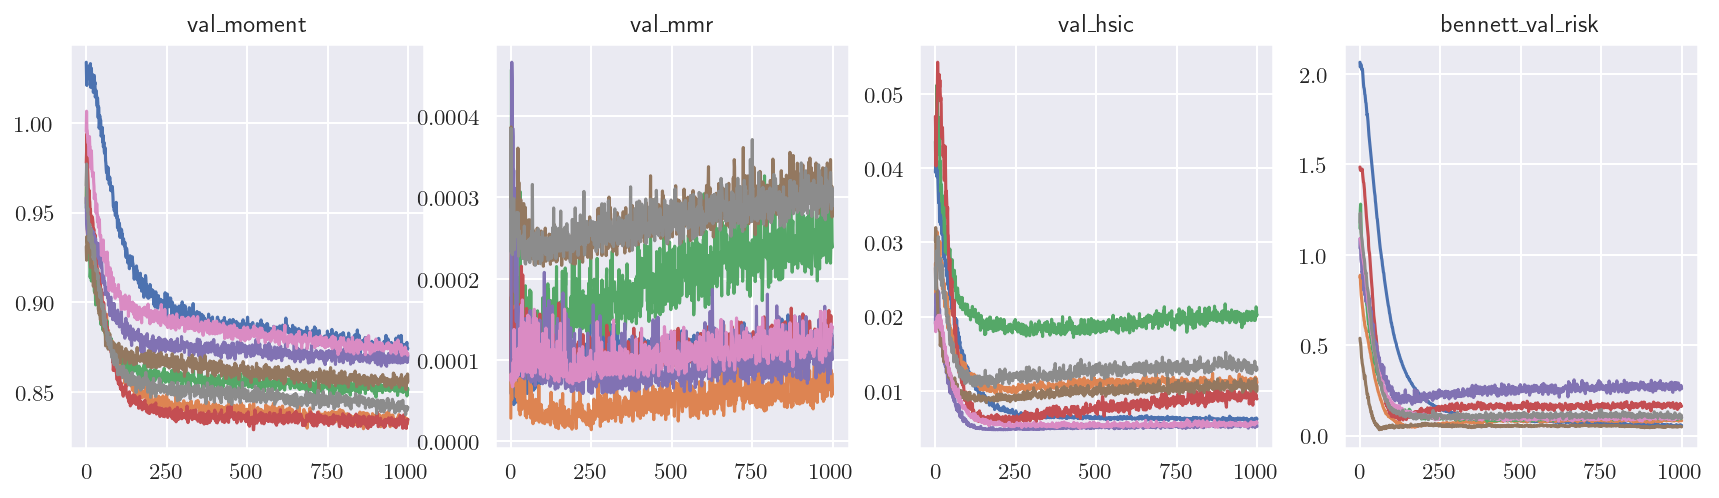

In [63]:
plot_val_loss_opt(kmm, config_id=28)

# EXP2: Network IV

## Load Data

In [112]:
func = 'step'
app = '_small'

vmm = load_and_merge_datasets(load_all_in_dir=f'/Users/hkremer/code/kmm/wasserstein-method-of-moments/results/network_iv{app}_{func}/',
                              method="VMM-neural")
    
    
fgel = load_and_merge_datasets(load_all_in_dir=f'/Users/hkremer/code/kmm/wasserstein-method-of-moments/results/network_iv{app}_{func}/',
                              method="FGEL-neural")    
    
kmm = load_and_merge_datasets(load_all_in_dir=f'/Users/hkremer/code/kmm/wasserstein-method-of-moments/results/network_iv{app}_{func}/',
                              method="KMM")

Found 9/9 files.
Found 19/19 files.
Found 457/457 files.


In [113]:
metric = 'val_loss'
val_loss_func = 'moment_violation'

## VMM

In [114]:
best_vmm = get_best_hparam_results(vmm, metric=metric, hparam_config={'val_loss_func': val_loss_func})
best_vmm

,test_risk,mse,val_loss,reg_param,version
config_id,,,,,
8,0.166250,0.0,0.766508,10.0000,8.0
7,0.166480,0.0,0.786157,1.0000,7.0
2,0.125288,0.0,0.885128,0.0001,2.0
6,0.114073,0.0,0.887636,0.0000,6.0
5,0.113993,0.0,0.906914,0.0100,5.0


## FGEL

In [115]:
best_fgel = get_best_hparam_results(fgel, metric=metric, hparam_config={'val_loss_func': val_loss_func})
best_fgel

,test_risk,mse,val_loss,reg_param,version
config_id,,,,,
14,0.155735,0.0,0.784582,10.0000,14.0
3,0.156433,0.0,0.790618,10.0000,3.0
10,0.155658,0.0,0.803057,10.0000,10.0
17,0.125802,0.0,0.852220,1.0000,17.0
15,0.117696,0.0,0.872809,1.0000,15.0
2,0.065127,0.0,1.038001,0.0100,2.0
16,0.058727,0.0,1.042867,0.0100,16.0
6,0.070464,0.0,1.044159,0.0000,6.0
18,0.084948,0.0,1.059179,0.0100,18.0


## KMM

In [116]:
best_kmm = get_best_hparam_results(kmm, metric=metric, hparam_config={'val_loss_func': val_loss_func,
                                                                      'n_reference_samples': [200],
                                                                      #"n_random_features": 10000,
                                                                      #"kde_bw": 1.0,
                                                                      #"batch_size": np.nan,
                                                                      #"reg_param": 1,
                                                                      #'entropy_reg_param': 1,
                                                                      "rkhs_reg_param": 1
                                                                     })
best_kmm

,test_risk,mse,val_loss,entropy_reg_param,reg_param,rkhs_reg_param,version,n_reference_samples,kde_bw
config_id,,,,,,,,,
406,0.076518,0.0,0.933178,10.0,0.10,1.0,406.0,200.0,1.0
380,0.070272,0.0,1.001512,1.0,0.10,1.0,380.0,200.0,1.0
99,0.072459,0.0,1.037076,10.0,0.01,1.0,99.0,200.0,1.0
74,0.085506,0.0,1.041384,0.1,1.00,1.0,74.0,200.0,1.0
167,0.069218,0.0,1.042402,10.0,0.01,1.0,167.0,200.0,0.1
213,0.074083,0.0,1.049850,0.1,10.00,1.0,213.0,200.0,0.1
405,0.084280,0.0,1.055177,0.1,0.01,1.0,405.0,200.0,1.0


In [81]:
from tabulate import tabulate

def generate_table_network_iv(n_train, methods, val_loss_func='mmr', kmm_hparam_config={}, small=False):
    funcs = ['abs', 'step', 'sin']
    
    if small:
        app = "_small"
    else:
        app = ''
    
    results = {func: {model: {} for model in methods} for func in funcs}
    for func in funcs:
        path = f"/Users/hkremer/code/kmm/wasserstein-method-of-moments/results/network_iv{app}_{func}/"
        for method in methods:
            hparam_config = kmm_hparam_config if method == 'KMM' else {}
            if method in ['FGEL-neural', 'VMM-neural', 'KMM']:
                hparam_config['val_loss_func'] = val_loss_func
            df = load_and_merge_datasets(load_all_in_dir=path, method=method)
            mean, sem = get_mean_and_sem(df, test_metric='test_risk', val_metric='val_loss',
                                         hparam_config=hparam_config)

            results[func][method] = {'mean': mean, 'sem': sem}

    row1 = [''] + [model for model in methods]
    table = [row1]
    for func in funcs:
        table.append([f'{func}'] + [
            r"${:.2f}\pm{:.2f}$".format(results[func][model]["mean"] * 1e1, results[func][model]["sem"] * 1e1) for
            model in results[func].keys()])
    print(tabulate(table, tablefmt="latex_raw"))

In [83]:
methods = ['OLS', 'SMD', "MMR", 'DeepIV', 'VMM-neural', 'FGEL-neural', 'KMM']

hparam_config={'val_loss_func': val_loss_func,
              #'n_reference_samples': [200],
              #"n_random_features": 10000,
             # "rkhs_reg_param": np.nan,
              }

generate_table_network_iv(n_train=None, methods=methods, val_loss_func='mmr', kmm_hparam_config=hparam_config, small=True)

Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 9/9 files.
Found 22/22 files.
Found 447/447 files.
Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 9/9 files.
Found 19/19 files.
Found 457/457 files.
Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 10/10 files.
Found 17/17 files.
Found 452/452 files.
\begin{tabular}{llllllll}
\hline
      & OLS           & SMD           & MMR           & DeepIV        & VMM-neural    & FGEL-neural   & KMM           \\
 abs  & $3.09\pm0.19$ & $1.19\pm0.23$ & $2.90\pm1.78$ & $2.03\pm1.14$ & $0.61\pm0.14$ & $0.43\pm0.12$ & $0.91\pm0.41$ \\
 step & $3.27\pm0.16$ & $0.96\pm0.16$ & $0.66\pm0.09$ & $0.82\pm0.08$ & $0.63\pm0.06$ & $0.57\pm0.08$ & $0.86\pm0.26$ \\
 sin  & $3.50\pm0.15$ & $1.97\pm0.37$ & $2.82\pm0.25$ & $3.61\pm0.35$ & $0.95\pm0.07$ & $1.32\pm0.21$ & $1.44\pm0.30$ \\
\hline
\end{tabular}


In [33]:
methods = ['OLS', 'SMD', "MMR", 'DeepIV', 'VMM-neural', 'FGEL-neural', 'KMM']

hparam_config={'val_loss_func': val_loss_func,
              'n_reference_samples': [200],
              "n_random_features": 10000,
              "rkhs_reg_param": np.nan,}

generate_table_network_iv(n_train=None, methods=methods, val_loss_func='moment_violation', kmm_hparam_config=hparam_config)

Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 10/10 files.
Found 24/24 files.
Found 933/933 files.
Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 9/9 files.
Found 26/26 files.
Found 937/937 files.
Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 9/9 files.
Found 28/28 files.
Found 931/931 files.
\begin{tabular}{llllllll}
\hline
      & OLS           & SMD           & MMR           & DeepIV        & VMM-neural    & FGEL-neural   & KMM           \\
 abs  & $3.27\pm0.40$ & $1.37\pm1.23$ & $1.40\pm1.06$ & $2.60\pm1.49$ & $0.17\pm0.04$ & $0.18\pm0.04$ & $0.15\pm0.02$ \\
 step & $2.95\pm0.10$ & $0.25\pm0.03$ & $0.50\pm0.05$ & $0.66\pm0.06$ & $0.26\pm0.06$ & $0.28\pm0.02$ & $0.26\pm0.02$ \\
 sin  & $3.27\pm0.07$ & $1.28\pm0.11$ & $2.54\pm0.29$ & $3.62\pm0.27$ & $0.86\pm0.08$ & $0.86\pm0.09$ & $0.89\pm0.09$ \\
\hline
\end{tabular}


In [34]:
methods = ['OLS', 'SMD', "MMR", 'DeepIV', 'VMM-neural', 'FGEL-neural', 'KMM']

hparam_config={'val_loss_func': val_loss_func,
              'n_reference_samples': [400],
              "n_random_features": 10000,
              "rkhs_reg_param": np.nan,}

generate_table_network_iv(n_train=None, methods=methods, val_loss_func='moment_violation', kmm_hparam_config=hparam_config)

Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 10/10 files.
Found 24/24 files.
Found 933/933 files.
Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 9/9 files.
Found 26/26 files.
Found 937/937 files.
Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 9/9 files.
Found 28/28 files.
Found 931/931 files.
\begin{tabular}{llllllll}
\hline
      & OLS           & SMD           & MMR           & DeepIV        & VMM-neural    & FGEL-neural   & KMM           \\
 abs  & $3.27\pm0.40$ & $1.37\pm1.23$ & $1.40\pm1.06$ & $2.60\pm1.49$ & $0.17\pm0.04$ & $0.18\pm0.04$ & $0.16\pm0.02$ \\
 step & $2.95\pm0.10$ & $0.25\pm0.03$ & $0.50\pm0.05$ & $0.66\pm0.06$ & $0.26\pm0.06$ & $0.28\pm0.02$ & $0.27\pm0.02$ \\
 sin  & $3.27\pm0.07$ & $1.28\pm0.11$ & $2.54\pm0.29$ & $3.62\pm0.27$ & $0.86\pm0.08$ & $0.86\pm0.09$ & $0.83\pm0.08$ \\
\hline
\end{tabular}


# Heteroskedastic one

In [39]:
n = 1024

kmm = load_and_merge_datasets(load_all_in_dir=f'/Users/hkremer/code/kmm/wasserstein-method-of-moments/results/heteroskedastic_one/n_{n}/',
                              method="KMM")

Found 83/83 files.


In [50]:
kmm

,,test_risk,mse,val_loss,train_stats,n_reference_samples,entropy_reg_param,reg_param,kde_bw,n_random_features,rkhs_func_z_dependent,t_as_instrument,val_loss_func,version
rollout,config_id,,,,,,,,,,,,,
0,0,NaN,NaN,NaN,"{'epochs': 185, 'val_loss': [0.000480607704957...",100,0.1,0.1,1.0,10000,False,True,mmr,0
1,0,NaN,NaN,NaN,"{'epochs': 66, 'val_loss': [0.0011649376247078...",100,0.1,0.1,1.0,10000,False,True,mmr,0
2,0,NaN,NaN,NaN,"{'epochs': 57, 'val_loss': [0.0001341686584055...",100,0.1,0.1,1.0,10000,False,True,mmr,0
3,0,33.405651,0.000595,0.000080,"{'epochs': 476, 'val_loss': [8.033214544411749...",100,0.1,0.1,1.0,10000,False,True,mmr,0
4,0,32.910564,0.056124,0.003544,"{'epochs': 408, 'val_loss': [0.003541370388120...",100,0.1,0.1,1.0,10000,False,True,mmr,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,82,33.946095,0.000788,0.000380,"{'epochs': 408, 'val_loss': [0.000326164183206...",0,1.0,0.1,1.0,10000,False,True,mmr,82
6,82,34.061115,0.007493,0.000398,"{'epochs': 476, 'val_loss': [0.000304126646369...",0,1.0,0.1,1.0,10000,False,True,mmr,82
7,82,34.312687,0.001955,0.000546,"{'epochs': 408, 'val_loss': [0.000472621846711...",0,1.0,0.1,1.0,10000,False,True,mmr,82


In [52]:
best_kmm = get_best_hparam_results(kmm, metric="mse", hparam_config={'val_loss_func': 'moment_violation',
                                                                     })
best_kmm

,test_risk,mse,val_loss,n_reference_samples,entropy_reg_param,reg_param,kde_bw,n_random_features,rkhs_func_z_dependent,t_as_instrument,version
config_id,,,,,,,,,,,
18,33.733530,0.003178,1.001871,200.0,1.0,0.1,0.1,10000.0,0.0,1.0,18.0
64,33.733530,0.003178,1.001871,200.0,1.0,0.1,1.0,10000.0,0.0,1.0,64.0
59,33.734203,0.003304,1.001782,100.0,1.0,0.1,0.1,10000.0,0.0,1.0,59.0
67,33.923206,0.003578,1.000039,100.0,0.1,10.0,0.1,10000.0,0.0,1.0,67.0
16,33.923206,0.003578,1.000039,100.0,0.1,10.0,1.0,10000.0,0.0,1.0,16.0
55,33.737675,0.003759,1.001757,0.0,1.0,0.1,0.1,10000.0,0.0,1.0,55.0
20,33.963175,0.003849,1.000077,100.0,0.1,1.0,1.0,10000.0,0.0,1.0,20.0
27,33.916746,0.003868,1.000033,100.0,0.1,0.1,1.0,10000.0,0.0,1.0,27.0
24,33.737927,0.003882,1.001701,0.0,1.0,0.1,1.0,10000.0,0.0,1.0,24.0


In [47]:
mean, sem = get_mean_and_sem(kmm, test_metric='mse', val_metric='val_loss')
print(mean, sem)

0.0035779720983839503 0.0030263801117826833


In [58]:
vmm = load_and_merge_datasets(load_all_in_dir=f'/Users/hkremer/code/kmm/wasserstein-method-of-moments/results/heteroskedastic_one/n_{n}/',
                              method="VMM-neural")
best_vmm = get_best_hparam_results(vmm, metric="val_loss", hparam_config={'val_loss_func': 'moment_violation',})
best_vmm

Found 10/10 files.


In [61]:
vmm

,,test_risk,mse,val_loss,train_stats,reg_param,val_loss_func,version
rollout,config_id,,,,,,,
0,0,34.490917,0.000060,1.003216,"{'epochs': 408, 'val_loss': [1.000026464462280...",0.0,moment_violation,0
1,0,33.599976,0.000550,1.001533,"{'epochs': 408, 'val_loss': [1.000175714492797...",0.0,moment_violation,0
2,0,32.550266,0.000081,1.002181,"{'epochs': 408, 'val_loss': [1.000002145767212...",0.0,moment_violation,0
3,0,33.405674,0.000314,1.000057,"{'epochs': 408, 'val_loss': [1.000005245208740...",0.0,moment_violation,0
4,0,32.691376,0.000225,1.015347,"{'epochs': 408, 'val_loss': [1.000244855880737...",0.0,moment_violation,0
...,...,...,...,...,...,...,...,...
5,9,33.959545,0.008567,0.000552,"{'epochs': 408, 'val_loss': [0.000326025299727...",10.0,mmr,9
6,9,34.033463,0.002511,0.000319,"{'epochs': 408, 'val_loss': [0.000304081884678...",10.0,mmr,9
7,9,34.354053,0.012660,0.000756,"{'epochs': 408, 'val_loss': [0.000472676969366...",10.0,mmr,9


In [64]:
best_vmm = get_best_hparam_results(vmm, metric="val_loss", hparam_config={'val_loss_func': 'moment_violation',})
best_vmm

,test_risk,mse,val_loss,reg_param,version
config_id,,,,,
6,33.837581,0.032996,0.998629,10.0000,6.0
7,33.770673,0.013234,0.999658,1.0000,7.0
8,33.724634,0.001356,1.002619,0.0100,8.0
3,33.718943,0.000370,1.002633,0.0001,3.0
0,33.718548,0.000363,1.002662,0.0000,0.0


In [79]:
val_loss_func = 'mmr'

Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 10/10 files.
Found 30/30 files.
Found 78/78 files.
Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 10/10 files.
Found 30/30 files.
Found 90/90 files.
Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 10/10 files.
Found 30/30 files.
Found 78/78 files.
Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 10/10 files.
Found 30/30 files.
Found 73/73 files.
Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 10/10 files.
Found 30/30 files.
Found 83/83 files.
Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 10/10 files.
Found 29/29 files.
Found 81/81 files.
Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 1/1 files.
Found 10/10 files.
Found 30/30 files.
Found 77/77 files.


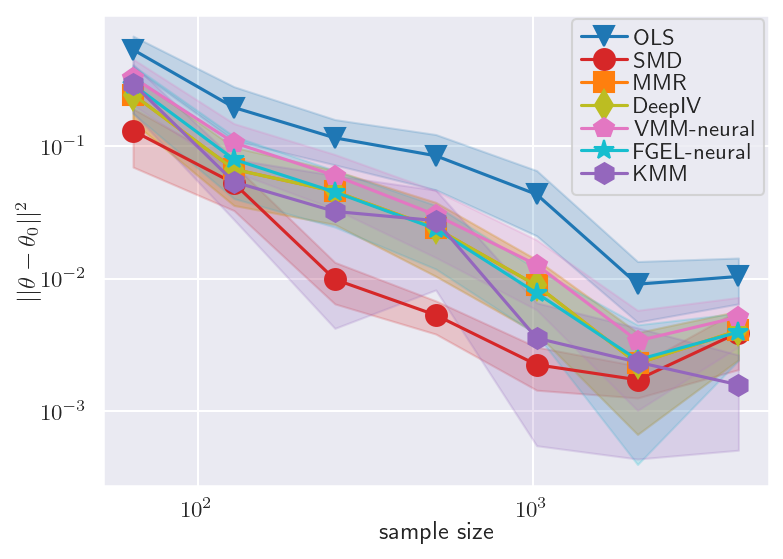

In [80]:
# def plot_results_over_sample_size(methods, n_samples, labels=None, hparam_config=None, logscale=False):

kmm_hparam_config = {}
plt.rcParams.update(NEURIPS_RCPARAMS)
sns.set_theme()

n_samples = [64, 128, 256, 512, 1024, 2048, 4096]
# if not labels:
labels = methods

marker = ['v', 'o', 's', 'd', 'p', '*', 'h'] * 2
colors = ['tab:blue', 'tab:red', 'tab:orange', 'tab:olive', 'tab:pink', 'tab:cyan', 'tab:purple'] * 2

results = {method: {'mean': [], 'sem': []} for method in methods}
n_samples = np.sort(n_samples)
for n_train in n_samples:
    for method in methods:
        hparam_config = kmm_hparam_config if method == 'KMM' else {}
        if method in ['FGEL-neural', 'VMM-neural', 'KMM']:
            hparam_config['val_loss_func'] = val_loss_func
            
        df = load_and_merge_datasets(load_all_in_dir=f'/Users/hkremer/code/kmm/wasserstein-method-of-moments/results/heteroskedastic_one/n_{n_train}/',
                                      method=method)
        mean, sem = get_mean_and_sem(df, test_metric='mse', val_metric='val_loss', hparam_config=hparam_config)
        results[method]['mean'].append(mean)
        results[method]['sem'].append(sem)

n_plots = 1
# figsize = (LINE_WIDTH, LINE_WIDTH / 2)
figsize = (LINE_WIDTH/1.3, LINE_WIDTH / 1.8)

fig, ax = plt.subplots(1, n_plots, figsize=figsize)
ax = [ax]

for i, (method, res) in enumerate(results.items()):
    ax[0].plot(n_samples, res['mean'], label="".join(labels[i]), color=colors[i], marker=marker[i], ms=10)
    ax[0].fill_between(n_samples,
                    np.subtract(res['mean'], res['sem']),
                    np.add(res['mean'], res['sem']),
                    alpha=0.2,
                    color=colors[i])

ax[0].set_xlabel('sample size')
ax[0].set_ylabel(r'$||\theta - \theta_0 ||^2$')
# if logscale:
ax[0].set_xscale('log')
ax[0].set_yscale('log')
#ax[0].set_xlim([1e2, 1e4])
# ax[0].set_ylim(ymax=1e0, ymin=1e-6) #[1e-5, 1.2e0])

plt.legend()
plt.tight_layout()
plt.savefig('exp_heteroskedastic.pdf', dpi=200)
plt.show()

In [78]:
vmm = load_and_merge_datasets(load_all_in_dir=f'/Users/hkremer/code/kmm/wasserstein-method-of-moments/results/heteroskedastic_one/n_1024/',
                              method="KMM")
best_vmm = get_best_hparam_results(vmm, metric="val_loss", hparam_config={'val_loss_func': 'moment_violation',})
best_vmm

Found 83/83 files.


,test_risk,mse,val_loss,n_reference_samples,entropy_reg_param,reg_param,kde_bw,n_random_features,rkhs_func_z_dependent,t_as_instrument,version
config_id,,,,,,,,,,,
73,33.861928,0.040127,0.998553,0.0,10.0,10.0,0.1,10000.0,0.0,1.0,73.0
8,33.861928,0.040127,0.998553,0.0,10.0,10.0,1.0,10000.0,0.0,1.0,8.0
22,33.856060,0.038224,0.998569,200.0,10.0,10.0,1.0,10000.0,0.0,1.0,22.0
57,33.856060,0.038224,0.998569,200.0,10.0,10.0,0.1,10000.0,0.0,1.0,57.0
49,33.849017,0.036506,0.998580,0.0,1.0,10.0,0.1,10000.0,0.0,1.0,49.0
26,33.847670,0.036233,0.998588,0.0,1.0,10.0,1.0,10000.0,0.0,1.0,26.0
21,33.846166,0.035757,0.998590,100.0,1.0,10.0,0.1,10000.0,0.0,1.0,21.0
51,33.843236,0.035138,0.998600,200.0,1.0,10.0,1.0,10000.0,0.0,1.0,51.0
13,33.837133,0.032638,0.998648,0.0,10.0,1.0,0.1,10000.0,0.0,1.0,13.0
